In [ ]:
# KITTI-360 3D Semantic Point Cloud Visualization

 # This notebook loads and visualizes PLY point cloud files from the KITTI-360 dataset using matplotlib.

# The dataset contains:
# Static point clouds : x, y, z, red, green, blue, semanticID, instanceID, isVisible, confidence**
# Dynamic point clouds: x, y, z, red, green, blue, semanticID, instanceID, isVisible, timestamp**

In [116]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import logging
from plyfile import PlyData, PlyElement

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

logger.info("Libraries imported successfully")


# Define the base directory for point cloud data
base_dir = "./extracted_3d_images/data_3d_semantics/train/2013_05_28_drive_0000_sync"

# List available PLY files
dynamic_dir = os.path.join(base_dir, "dynamic")
static_dir = os.path.join(base_dir, "static")

# Get lists of PLY files
dynamic_files = sorted([f for f in os.listdir(dynamic_dir) if f.endswith('.ply')])
static_files = sorted([f for f in os.listdir(static_dir) if f.endswith('.ply')])

logger.info(f"Found {len(dynamic_files)} dynamic PLY files")
logger.info(f"Found {len(static_files)} static PLY files")

2025-11-04 15:41:00,517 - INFO - Libraries imported successfully
2025-11-04 15:41:00,523 - INFO - Found 44 dynamic PLY files
2025-11-04 15:41:00,524 - INFO - Found 44 static PLY files
2025-11-04 15:41:00,523 - INFO - Found 44 dynamic PLY files
2025-11-04 15:41:00,524 - INFO - Found 44 static PLY files


In [110]:
def load_ply_file(file_path, point_type='static'):
    """
    Load a KITTI-360 PLY file and extract point cloud data with semantic information.
    
    Args:
        file_path: Path to the PLY file
        point_type: 'static' or 'dynamic' to indicate expected format
        
    Returns:
        data_dict: Dictionary containing:
            - points: Nx3 numpy array of point coordinates (x, y, z)
            - colors: Nx3 numpy array of RGB colors (normalized 0-1)
            - semantic_ids: N numpy array of semantic IDs (if available)
            - instance_ids: N numpy array of instance IDs (if available)
            - is_visible: N numpy array of visibility flags (if available)
            - confidence: N numpy array of confidence values (if available, static only)
            - timestamps: N numpy array of timestamps (if available, dynamic only)
    """
    logger.info(f"Loading {point_type} PLY file: {file_path}")
    
    try:
        ply_data = PlyData.read(file_path)
        vertex_data = ply_data['vertex']
        
        data_dict = {}
        
        # Extract XYZ coordinates (always present)
        x = np.array(vertex_data['x'])
        y = np.array(vertex_data['y'])
        z = np.array(vertex_data['z'])
        data_dict['points'] = np.column_stack((x, y, z))
        
        # Extract RGB colors (always present)
        if 'red' in vertex_data.data.dtype.names:
            r = np.array(vertex_data['red']) / 255.0
            g = np.array(vertex_data['green']) / 255.0
            b = np.array(vertex_data['blue']) / 255.0
            data_dict['colors'] = np.column_stack((r, g, b))
        else:
            data_dict['colors'] = None
        
        # Extract semantic and instance IDs (training data)
        if 'semantic' in vertex_data.data.dtype.names:
            data_dict['semantic_ids'] = np.array(vertex_data['semantic'])
        elif 'semanticId' in vertex_data.data.dtype.names:
            data_dict['semantic_ids'] = np.array(vertex_data['semanticId'])
        else:
            data_dict['semantic_ids'] = None
            
        if 'instance' in vertex_data.data.dtype.names:
            data_dict['instance_ids'] = np.array(vertex_data['instance'])
        elif 'instanceId' in vertex_data.data.dtype.names:
            data_dict['instance_ids'] = np.array(vertex_data['instanceId'])
        else:
            data_dict['instance_ids'] = None
        
        # Extract visibility flag
        if 'isVisible' in vertex_data.data.dtype.names:
            data_dict['is_visible'] = np.array(vertex_data['isVisible'])
        else:
            data_dict['is_visible'] = None
        
        # Extract confidence (static points only)
        if 'confidence' in vertex_data.data.dtype.names:
            data_dict['confidence'] = np.array(vertex_data['confidence'])
        else:
            data_dict['confidence'] = None
        
        # Extract timestamp (dynamic points only)
        if 'timestamp' in vertex_data.data.dtype.names:
            data_dict['timestamps'] = np.array(vertex_data['timestamp'])
        else:
            data_dict['timestamps'] = None
        
        # Log what was loaded
        n_points = len(data_dict['points'])
        logger.info(f"Loaded {n_points} points")
        if data_dict['semantic_ids'] is not None:
            unique_semantics = len(np.unique(data_dict['semantic_ids']))
            logger.info(f"  - {unique_semantics} unique semantic classes")
        if data_dict['instance_ids'] is not None:
            unique_instances = len(np.unique(data_dict['instance_ids']))
            logger.info(f"  - {unique_instances} unique instances")
        if data_dict['is_visible'] is not None:
            visible_count = np.sum(data_dict['is_visible'])
            logger.info(f"  - {visible_count}/{n_points} visible points")
        if data_dict['timestamps'] is not None and len(data_dict['timestamps']) > 0:
            logger.info(f"  - Timestamp range: {data_dict['timestamps'].min()} to {data_dict['timestamps'].max()}")
        
        return data_dict
    
    except Exception as e:
        logger.error(f"Error loading PLY file: {e}")
        raise

In [111]:
def visualize_point_cloud(data_dict, title="3D Point Cloud", point_size=1, subsample=None, 
                          color_by='rgb', colormap='tab20'):
    """
    Visualize a 3D point cloud using matplotlib with various coloring options.
    
    Args:
        data_dict: Dictionary from load_ply_file() containing point cloud data
        title: Title for the plot
        point_size: Size of points in the plot
        subsample: If set, randomly sample this many points for faster rendering
        color_by: How to color points: 'rgb', 'semantic', 'instance', 'visibility', 'confidence', 'timestamp', 'z'
        colormap: Matplotlib colormap for non-RGB coloring
    """
    points = data_dict['points']
    logger.info(f"Visualizing point cloud with {len(points)} points, colored by {color_by}")
    
    # Check if point cloud is empty
    if len(points) == 0:
        logger.error("Cannot visualize empty point cloud")
        print("Error: Point cloud is empty, nothing to visualize.")
        return
    
    # Subsample if requested (for faster rendering)
    indices = np.arange(len(points))
    if subsample and len(points) > subsample:
        indices = np.random.choice(len(points), subsample, replace=False)
        logger.info(f"Subsampled to {len(indices)} points for visualization")
    
    points_sub = points[indices]
    
    # Check if subsampled points is empty
    if len(points_sub) == 0:
        logger.error("Cannot visualize empty point cloud after subsampling")
        print("Error: Point cloud is empty after subsampling, nothing to visualize.")
        return
    
    # Create 3D plot
    fig = plt.figure(figsize=(14, 11))
    ax = fig.add_subplot(111, projection='3d')
    
    # Determine coloring
    colors = None
    color_data = None
    
    if color_by == 'rgb' and data_dict['colors'] is not None:
        colors = data_dict['colors'][indices]
        scatter = ax.scatter(points_sub[:, 0], points_sub[:, 1], points_sub[:, 2], 
                           c=colors, s=point_size, alpha=0.6)
    elif color_by == 'semantic' and data_dict['semantic_ids'] is not None:
        color_data = data_dict['semantic_ids'][indices]
        scatter = ax.scatter(points_sub[:, 0], points_sub[:, 1], points_sub[:, 2], 
                           c=color_data, cmap=colormap, s=point_size, alpha=0.6)
        cbar = fig.colorbar(scatter, ax=ax, label='Semantic ID', pad=0.1)
    elif color_by == 'instance' and data_dict['instance_ids'] is not None:
        color_data = data_dict['instance_ids'][indices]
        scatter = ax.scatter(points_sub[:, 0], points_sub[:, 1], points_sub[:, 2], 
                           c=color_data, cmap=colormap, s=point_size, alpha=0.6)
        cbar = fig.colorbar(scatter, ax=ax, label='Instance ID', pad=0.1)
    elif color_by == 'visibility' and data_dict['is_visible'] is not None:
        color_data = data_dict['is_visible'][indices]
        scatter = ax.scatter(points_sub[:, 0], points_sub[:, 1], points_sub[:, 2], 
                           c=color_data, cmap='RdYlGn', s=point_size, alpha=0.6, vmin=0, vmax=1)
        cbar = fig.colorbar(scatter, ax=ax, label='Visibility (0=hidden, 1=visible)', pad=0.1)
    elif color_by == 'confidence' and data_dict['confidence'] is not None:
        color_data = data_dict['confidence'][indices]
        scatter = ax.scatter(points_sub[:, 0], points_sub[:, 1], points_sub[:, 2], 
                           c=color_data, cmap='viridis', s=point_size, alpha=0.6, vmin=0, vmax=1)
        cbar = fig.colorbar(scatter, ax=ax, label='Confidence', pad=0.1)
    elif color_by == 'timestamp' and data_dict['timestamps'] is not None:
        color_data = data_dict['timestamps'][indices]
        scatter = ax.scatter(points_sub[:, 0], points_sub[:, 1], points_sub[:, 2], 
                           c=color_data, cmap='plasma', s=point_size, alpha=0.6)
        cbar = fig.colorbar(scatter, ax=ax, label='Timestamp', pad=0.1)
    else:
        # Default: color by Z-coordinate
        color_data = points_sub[:, 2]
        scatter = ax.scatter(points_sub[:, 0], points_sub[:, 1], points_sub[:, 2], 
                           c=color_data, cmap='viridis', s=point_size, alpha=0.6)
        cbar = fig.colorbar(scatter, ax=ax, label='Z coordinate (m)', pad=0.1)
    
    # Set labels and title
    ax.set_xlabel('X (meters)', fontsize=11)
    ax.set_ylabel('Y (meters)', fontsize=11)
    ax.set_zlabel('Z (meters)', fontsize=11)
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Set equal aspect ratio for better visualization
    max_range = np.array([points_sub[:, 0].max() - points_sub[:, 0].min(),
                         points_sub[:, 1].max() - points_sub[:, 1].min(),
                         points_sub[:, 2].max() - points_sub[:, 2].min()]).max() / 2.0
    
    mid_x = (points_sub[:, 0].max() + points_sub[:, 0].min()) * 0.5
    mid_y = (points_sub[:, 1].max() + points_sub[:, 1].min()) * 0.5
    mid_z = (points_sub[:, 2].max() + points_sub[:, 2].min()) * 0.5
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    
    plt.tight_layout()
    logger.info("Point cloud visualization complete")
    plt.show()

## Visualize Dynamic Point Clouds

Let's load and visualize the first 10 dynamic PLY files with RGB colors:

2025-11-04 15:38:58,086 - INFO - Loading dynamic PLY file: ./extracted_3d_images/data_3d_semantics/train/2013_05_28_drive_0000_sync\dynamic\0000000002_0000000385.ply
2025-11-04 15:38:58,134 - INFO - Loaded 0 points
2025-11-04 15:38:58,135 - INFO -   - 0 unique semantic classes
2025-11-04 15:38:58,137 - INFO -   - 0 unique instances
2025-11-04 15:38:58,145 - INFO - Visualizing point cloud with 0 points, colored by rgb
2025-11-04 15:38:58,134 - INFO - Loaded 0 points
2025-11-04 15:38:58,135 - INFO -   - 0 unique semantic classes
2025-11-04 15:38:58,137 - INFO -   - 0 unique instances
2025-11-04 15:38:58,145 - INFO - Visualizing point cloud with 0 points, colored by rgb
2025-11-04 15:38:58,146 - ERROR - Cannot visualize empty point cloud
2025-11-04 15:38:58,148 - INFO - Loading dynamic PLY file: ./extracted_3d_images/data_3d_semantics/train/2013_05_28_drive_0000_sync\dynamic\0000000372_0000000610.ply
2025-11-04 15:38:58,146 - ERROR - Cannot visualize empty point cloud
2025-11-04 15:38:58,


Loading file 1/10: 0000000002_0000000385.ply
Error: Point cloud is empty, nothing to visualize.

Loading file 2/10: 0000000372_0000000610.ply
Error: Point cloud is empty, nothing to visualize.

Loading file 3/10: 0000000599_0000000846.ply
Error: Point cloud is empty, nothing to visualize.

Loading file 4/10: 0000000834_0000001286.ply


2025-11-04 15:38:58,290 - INFO -   - 1 unique semantic classes
2025-11-04 15:38:58,291 - INFO -   - 1 unique instances
2025-11-04 15:38:58,293 - INFO -   - Timestamp range: 921 to 1181
2025-11-04 15:38:58,294 - INFO - Visualizing point cloud with 35388 points, colored by rgb
2025-11-04 15:38:58,291 - INFO -   - 1 unique instances
2025-11-04 15:38:58,293 - INFO -   - Timestamp range: 921 to 1181
2025-11-04 15:38:58,294 - INFO - Visualizing point cloud with 35388 points, colored by rgb
2025-11-04 15:38:58,351 - INFO - Point cloud visualization complete
2025-11-04 15:38:58,351 - INFO - Point cloud visualization complete


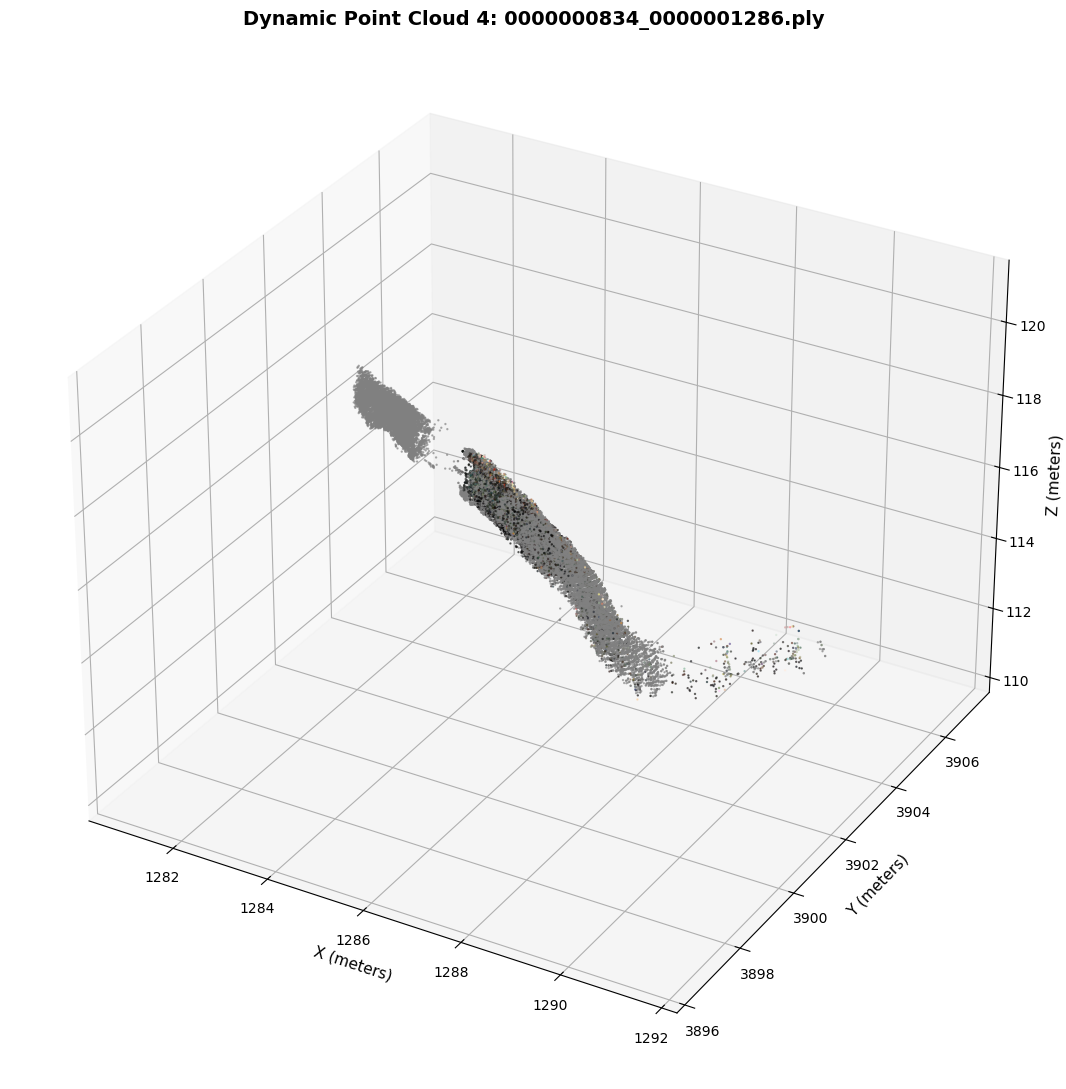

2025-11-04 15:38:59,118 - INFO - Loading dynamic PLY file: ./extracted_3d_images/data_3d_semantics/train/2013_05_28_drive_0000_sync\dynamic\0000001270_0000001549.ply
2025-11-04 15:38:59,144 - INFO - Loaded 20118 points
2025-11-04 15:38:59,144 - INFO - Loaded 20118 points
2025-11-04 15:38:59,146 - INFO -   - 2 unique semantic classes
2025-11-04 15:38:59,147 - INFO -   - 2 unique instances
2025-11-04 15:38:59,148 - INFO -   - Timestamp range: 1453 to 1508
2025-11-04 15:38:59,149 - INFO - Visualizing point cloud with 20118 points, colored by rgb
2025-11-04 15:38:59,146 - INFO -   - 2 unique semantic classes
2025-11-04 15:38:59,147 - INFO -   - 2 unique instances
2025-11-04 15:38:59,148 - INFO -   - Timestamp range: 1453 to 1508
2025-11-04 15:38:59,149 - INFO - Visualizing point cloud with 20118 points, colored by rgb
2025-11-04 15:38:59,228 - INFO - Point cloud visualization complete
2025-11-04 15:38:59,228 - INFO - Point cloud visualization complete



Loading file 5/10: 0000001270_0000001549.ply


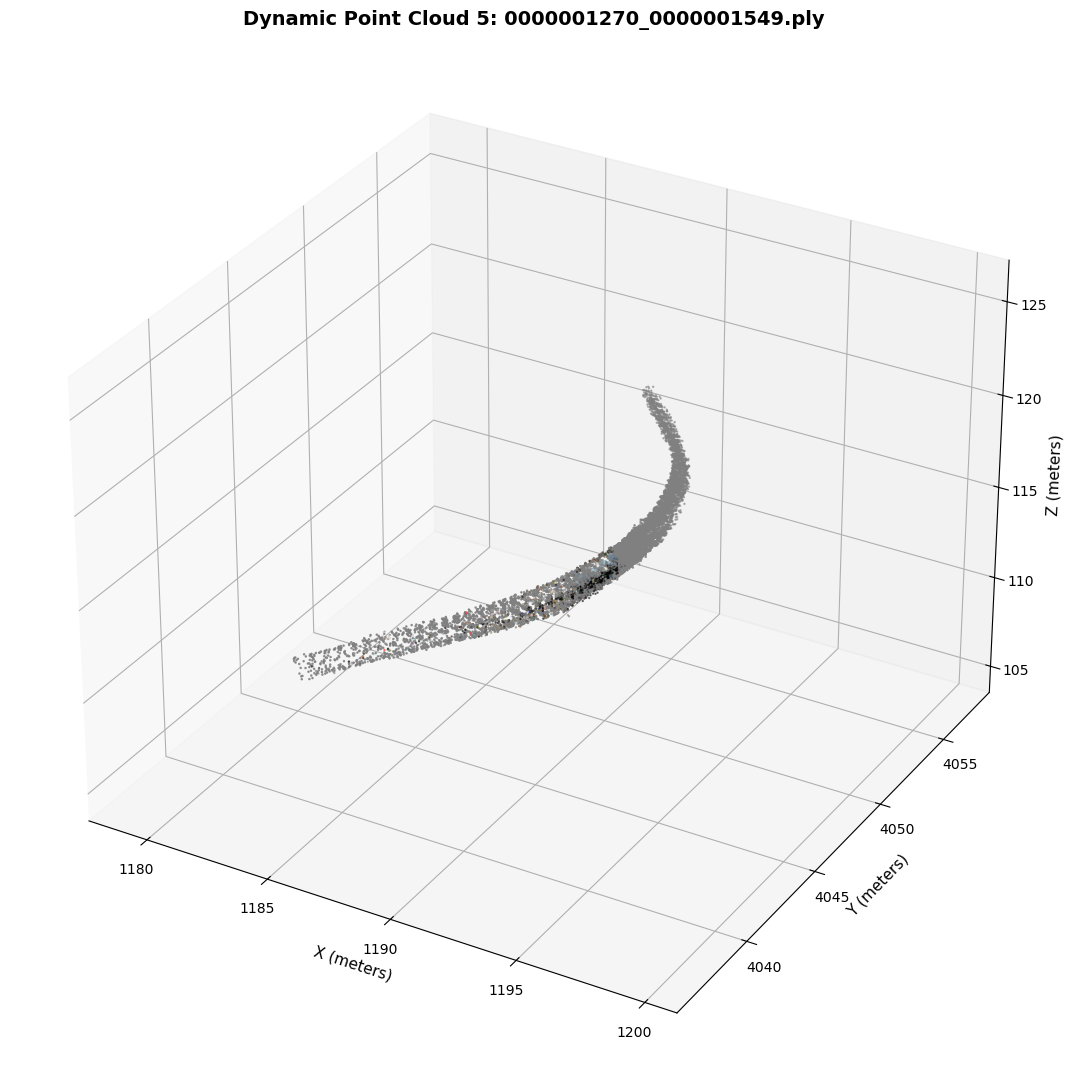

2025-11-04 15:38:59,722 - INFO - Loading dynamic PLY file: ./extracted_3d_images/data_3d_semantics/train/2013_05_28_drive_0000_sync\dynamic\0000001537_0000001755.ply
2025-11-04 15:38:59,734 - INFO - Loaded 0 points
2025-11-04 15:38:59,735 - INFO -   - 0 unique semantic classes
2025-11-04 15:38:59,735 - INFO -   - 0 unique instances
2025-11-04 15:38:59,734 - INFO - Loaded 0 points
2025-11-04 15:38:59,735 - INFO -   - 0 unique semantic classes
2025-11-04 15:38:59,735 - INFO -   - 0 unique instances
2025-11-04 15:38:59,737 - INFO - Visualizing point cloud with 0 points, colored by rgb
2025-11-04 15:38:59,739 - ERROR - Cannot visualize empty point cloud
2025-11-04 15:38:59,740 - INFO - Loading dynamic PLY file: ./extracted_3d_images/data_3d_semantics/train/2013_05_28_drive_0000_sync\dynamic\0000001740_0000001991.ply
2025-11-04 15:38:59,748 - INFO - Loaded 0 points
2025-11-04 15:38:59,737 - INFO - Visualizing point cloud with 0 points, colored by rgb
2025-11-04 15:38:59,739 - ERROR - Cannot


Loading file 6/10: 0000001537_0000001755.ply
Error: Point cloud is empty, nothing to visualize.

Loading file 7/10: 0000001740_0000001991.ply
Error: Point cloud is empty, nothing to visualize.

Loading file 8/10: 0000001980_0000002295.ply


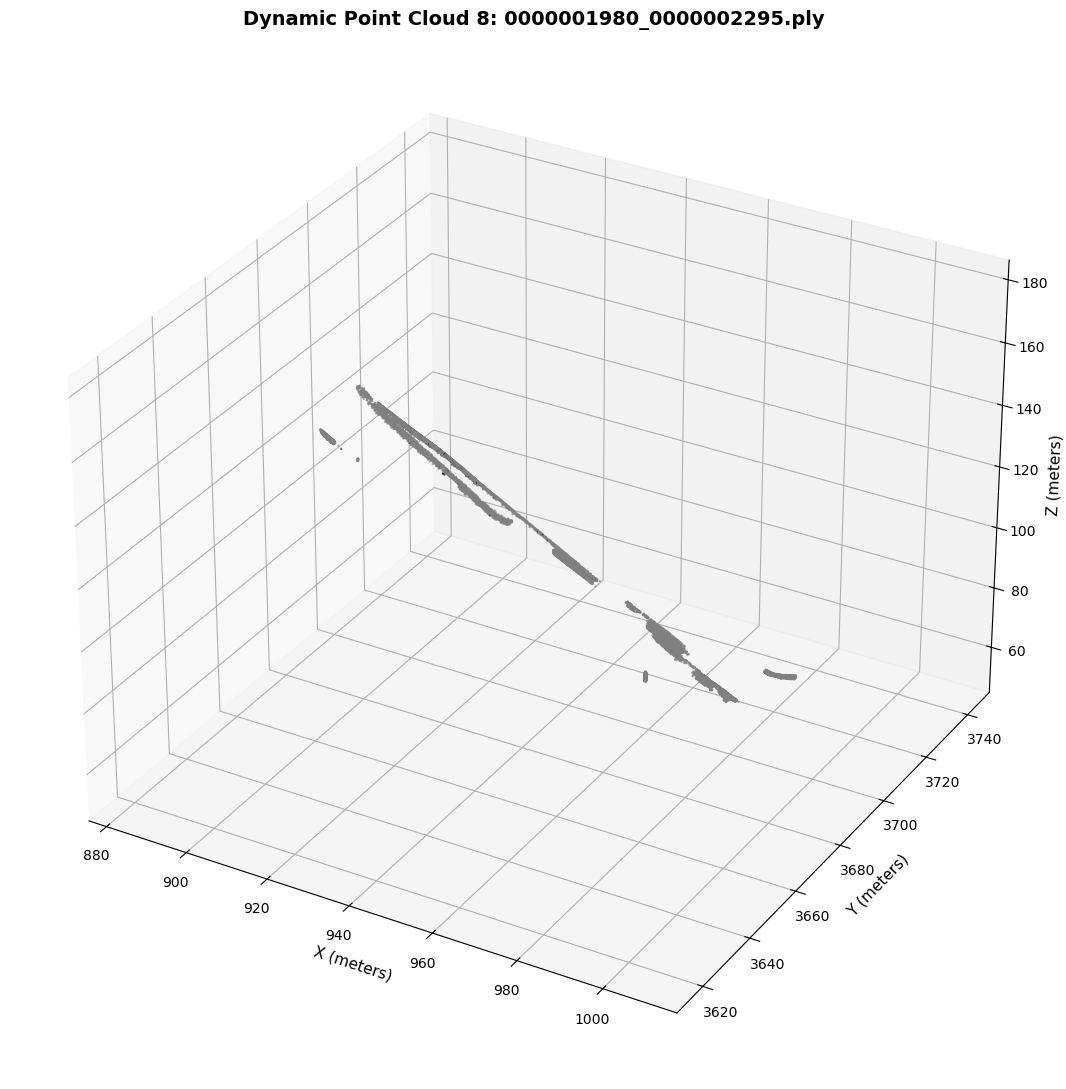

2025-11-04 15:39:00,365 - INFO - Loading dynamic PLY file: ./extracted_3d_images/data_3d_semantics/train/2013_05_28_drive_0000_sync\dynamic\0000002282_0000002514.ply
2025-11-04 15:39:00,460 - INFO - Loaded 213029 points
2025-11-04 15:39:00,464 - INFO -   - 4 unique semantic classes
2025-11-04 15:39:00,468 - INFO -   - 14 unique instances
2025-11-04 15:39:00,469 - INFO -   - Timestamp range: 2290 to 2514
2025-11-04 15:39:00,460 - INFO - Loaded 213029 points
2025-11-04 15:39:00,464 - INFO -   - 4 unique semantic classes
2025-11-04 15:39:00,468 - INFO -   - 14 unique instances
2025-11-04 15:39:00,469 - INFO -   - Timestamp range: 2290 to 2514
2025-11-04 15:39:00,472 - INFO - Visualizing point cloud with 213029 points, colored by rgb
2025-11-04 15:39:00,480 - INFO - Subsampled to 50000 points for visualization
2025-11-04 15:39:00,472 - INFO - Visualizing point cloud with 213029 points, colored by rgb
2025-11-04 15:39:00,480 - INFO - Subsampled to 50000 points for visualization
2025-11-04 1


Loading file 9/10: 0000002282_0000002514.ply


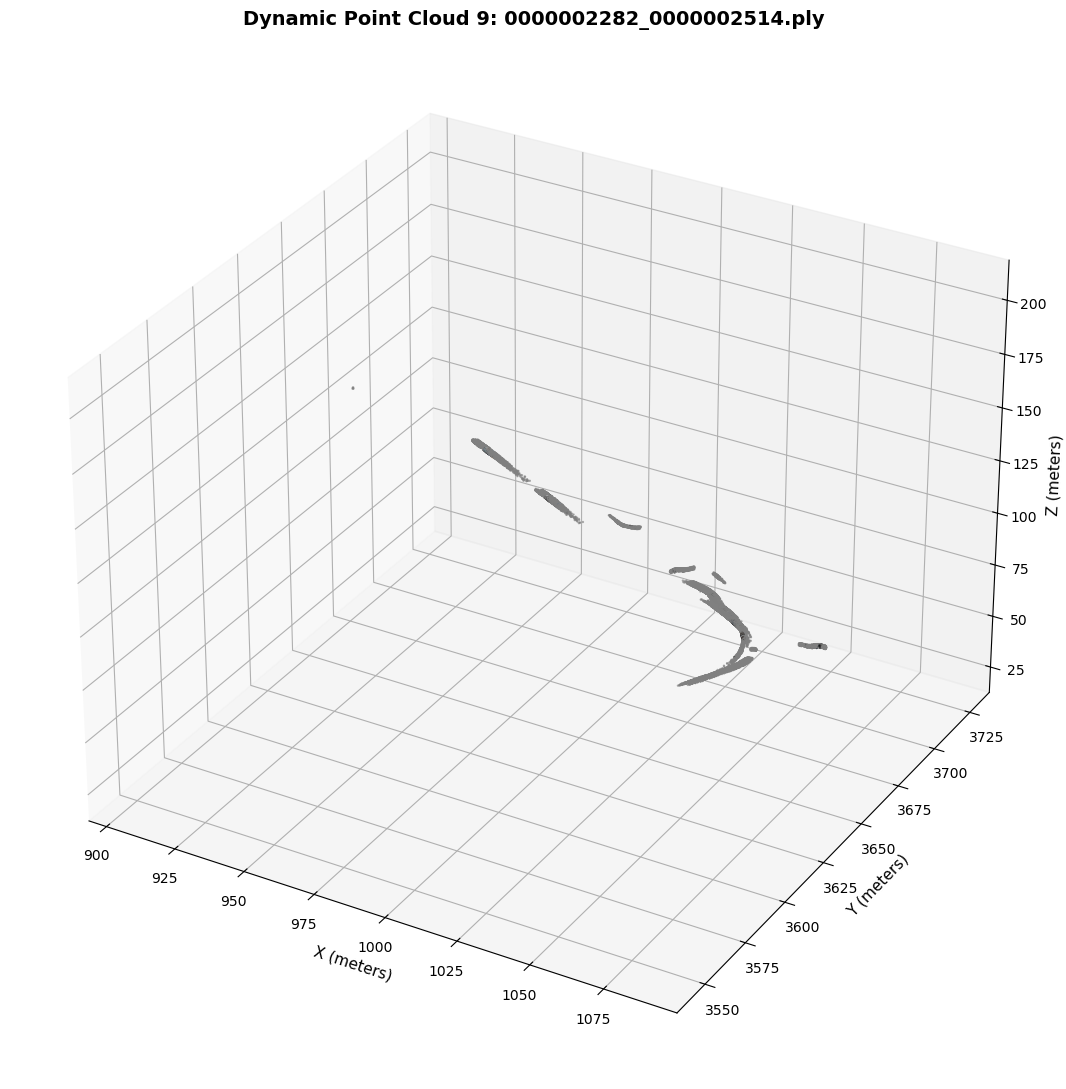

2025-11-04 15:39:01,531 - INFO - Loading dynamic PLY file: ./extracted_3d_images/data_3d_semantics/train/2013_05_28_drive_0000_sync\dynamic\0000002501_0000002706.ply
2025-11-04 15:39:01,590 - INFO - Loaded 95101 points
2025-11-04 15:39:01,592 - INFO -   - 4 unique semantic classes
2025-11-04 15:39:01,594 - INFO -   - 6 unique instances
2025-11-04 15:39:01,595 - INFO -   - Timestamp range: 2501 to 2725
2025-11-04 15:39:01,598 - INFO - Visualizing point cloud with 95101 points, colored by rgb
2025-11-04 15:39:01,602 - INFO - Subsampled to 50000 points for visualization
2025-11-04 15:39:01,590 - INFO - Loaded 95101 points
2025-11-04 15:39:01,592 - INFO -   - 4 unique semantic classes
2025-11-04 15:39:01,594 - INFO -   - 6 unique instances
2025-11-04 15:39:01,595 - INFO -   - Timestamp range: 2501 to 2725
2025-11-04 15:39:01,598 - INFO - Visualizing point cloud with 95101 points, colored by rgb
2025-11-04 15:39:01,602 - INFO - Subsampled to 50000 points for visualization



Loading file 10/10: 0000002501_0000002706.ply


2025-11-04 15:39:01,831 - INFO - Point cloud visualization complete


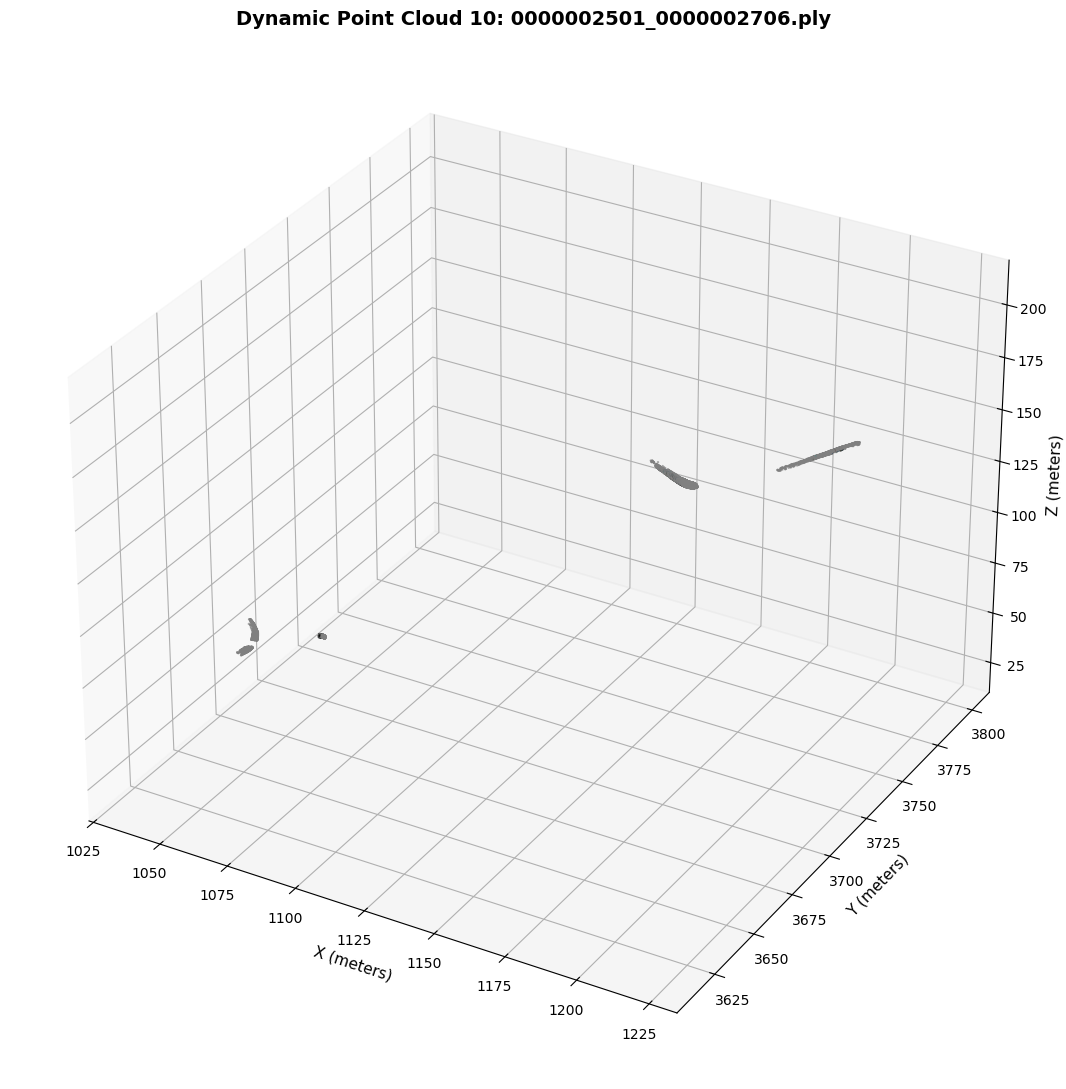

In [112]:
# Load and visualize first 10 dynamic point cloud files
num_files = min(10, len(dynamic_files))

for i in range(num_files):
    ply_file = os.path.join(dynamic_dir, dynamic_files[i])
    print(f"\n{'='*60}")
    print(f"Loading file {i+1}/{num_files}: {dynamic_files[i]}")
    print(f"{'='*60}")
    
    # Load the point cloud
    data = load_ply_file(ply_file, point_type='dynamic')
    
    # Visualize with RGB colors
    visualize_point_cloud(data, 
                         title=f"Dynamic Point Cloud {i+1}: {dynamic_files[i]}", 
                         point_size=0.5, 
                         subsample=50000,
                         color_by='rgb')

## Visualize First 10 Static Point Clouds

Let's load and visualize the first 10 static PLY files with RGB colors:

2025-11-04 15:39:02,848 - INFO - Loading static PLY file: ./extracted_3d_images/data_3d_semantics/train/2013_05_28_drive_0000_sync\static\0000000002_0000000385.ply



Loading file 1/10: 0000000002_0000000385.ply


2025-11-04 15:39:03,626 - INFO - Loaded 3201318 points
2025-11-04 15:39:03,729 - INFO -   - 21 unique semantic classes
2025-11-04 15:39:03,729 - INFO -   - 21 unique semantic classes
2025-11-04 15:39:03,829 - INFO -   - 108 unique instances
2025-11-04 15:39:03,829 - INFO -   - 108 unique instances
2025-11-04 15:39:03,876 - INFO - Visualizing point cloud with 3201318 points, colored by rgb
2025-11-04 15:39:03,876 - INFO - Visualizing point cloud with 3201318 points, colored by rgb
2025-11-04 15:39:04,067 - INFO - Subsampled to 50000 points for visualization
2025-11-04 15:39:04,067 - INFO - Subsampled to 50000 points for visualization
2025-11-04 15:39:04,152 - INFO - Point cloud visualization complete
2025-11-04 15:39:04,152 - INFO - Point cloud visualization complete


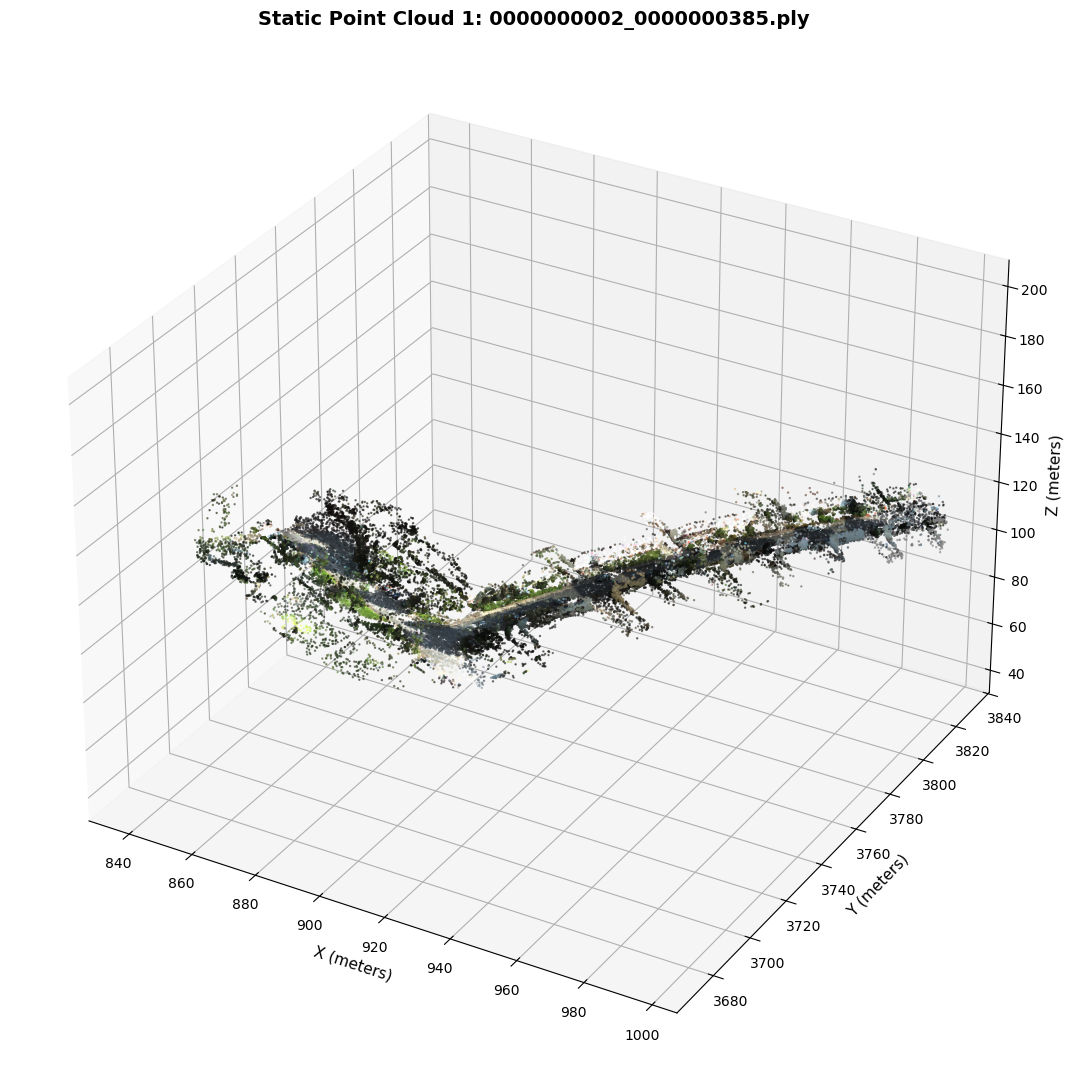

2025-11-04 15:39:05,133 - INFO - Loading static PLY file: ./extracted_3d_images/data_3d_semantics/train/2013_05_28_drive_0000_sync\static\0000000372_0000000610.ply



Loading file 2/10: 0000000372_0000000610.ply


2025-11-04 15:39:05,804 - INFO - Loaded 3063621 points
2025-11-04 15:39:05,874 - INFO -   - 21 unique semantic classes
2025-11-04 15:39:05,874 - INFO -   - 21 unique semantic classes
2025-11-04 15:39:05,957 - INFO -   - 85 unique instances
2025-11-04 15:39:05,957 - INFO -   - 85 unique instances
2025-11-04 15:39:06,009 - INFO - Visualizing point cloud with 3063621 points, colored by rgb
2025-11-04 15:39:06,009 - INFO - Visualizing point cloud with 3063621 points, colored by rgb
2025-11-04 15:39:06,200 - INFO - Subsampled to 50000 points for visualization
2025-11-04 15:39:06,200 - INFO - Subsampled to 50000 points for visualization
2025-11-04 15:39:06,266 - INFO - Point cloud visualization complete
2025-11-04 15:39:06,266 - INFO - Point cloud visualization complete


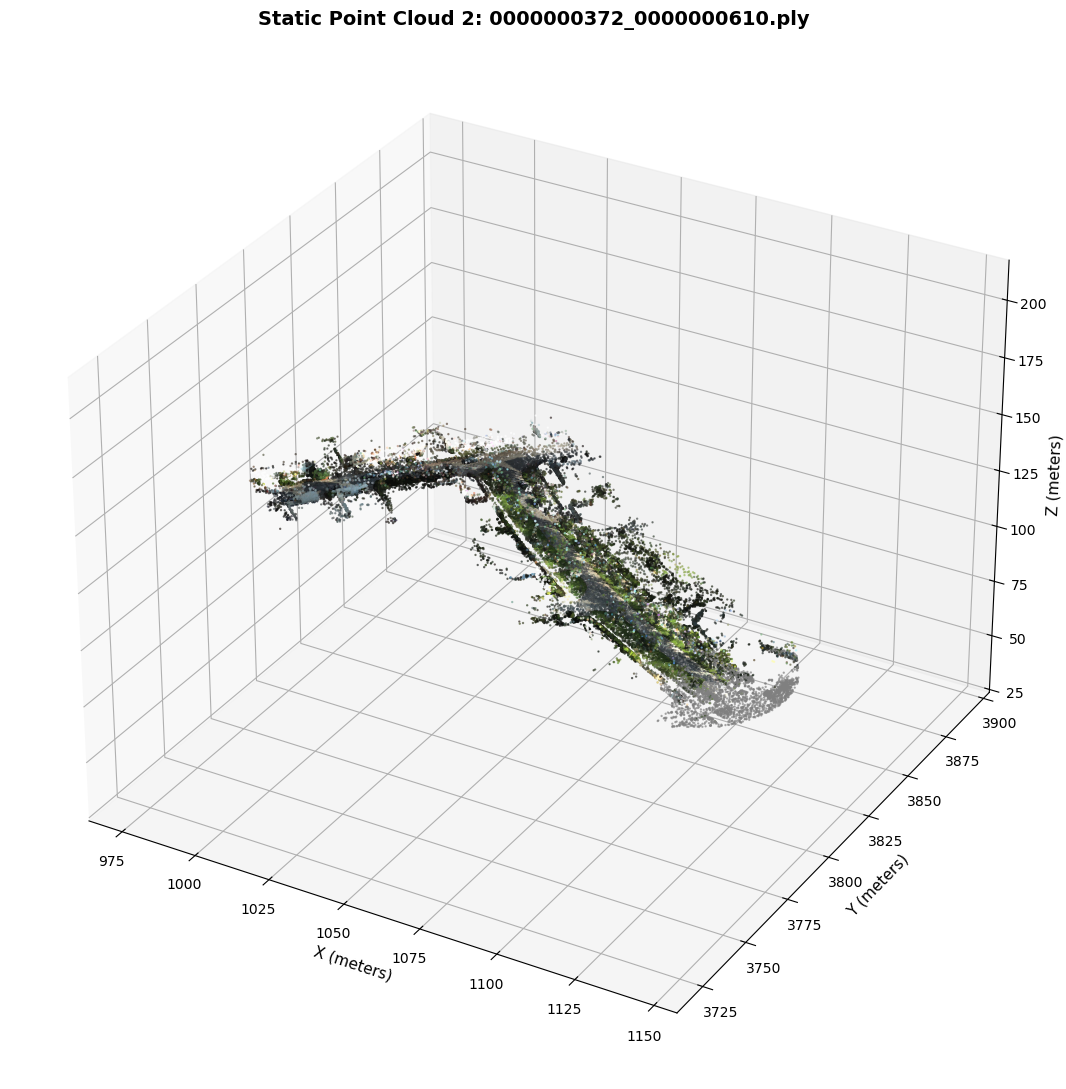

2025-11-04 15:39:07,315 - INFO - Loading static PLY file: ./extracted_3d_images/data_3d_semantics/train/2013_05_28_drive_0000_sync\static\0000000599_0000000846.ply



Loading file 3/10: 0000000599_0000000846.ply


2025-11-04 15:39:08,114 - INFO - Loaded 3503785 points
2025-11-04 15:39:08,203 - INFO -   - 23 unique semantic classes
2025-11-04 15:39:08,203 - INFO -   - 23 unique semantic classes
2025-11-04 15:39:08,304 - INFO -   - 112 unique instances
2025-11-04 15:39:08,304 - INFO -   - 112 unique instances
2025-11-04 15:39:08,332 - INFO - Visualizing point cloud with 3503785 points, colored by rgb
2025-11-04 15:39:08,332 - INFO - Visualizing point cloud with 3503785 points, colored by rgb
2025-11-04 15:39:08,531 - INFO - Subsampled to 50000 points for visualization
2025-11-04 15:39:08,531 - INFO - Subsampled to 50000 points for visualization
2025-11-04 15:39:08,630 - INFO - Point cloud visualization complete
2025-11-04 15:39:08,630 - INFO - Point cloud visualization complete


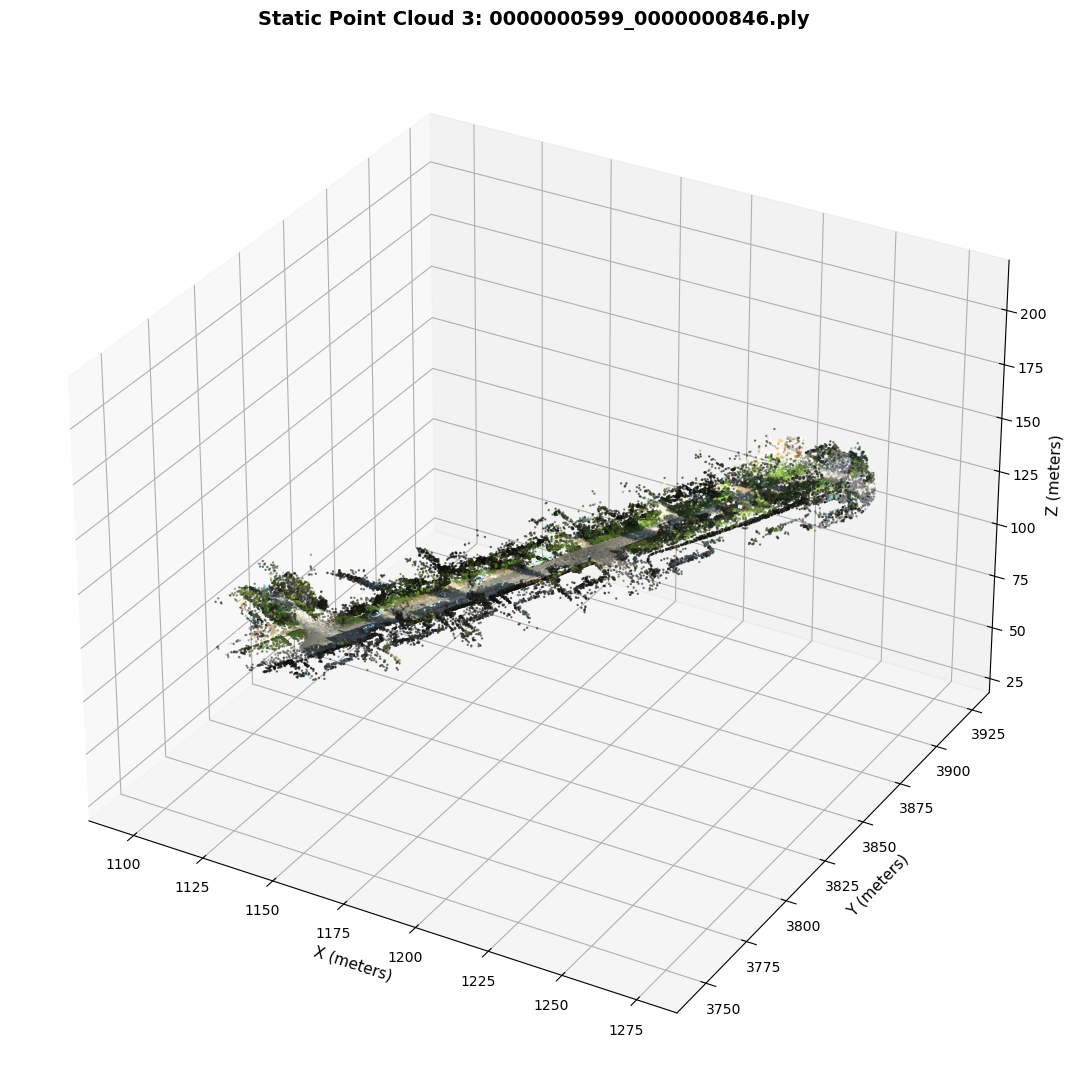

2025-11-04 15:39:09,686 - INFO - Loading static PLY file: ./extracted_3d_images/data_3d_semantics/train/2013_05_28_drive_0000_sync\static\0000000834_0000001286.ply



Loading file 4/10: 0000000834_0000001286.ply


2025-11-04 15:39:10,556 - INFO - Loaded 3609825 points
2025-11-04 15:39:10,643 - INFO -   - 17 unique semantic classes
2025-11-04 15:39:10,643 - INFO -   - 17 unique semantic classes
2025-11-04 15:39:10,769 - INFO -   - 66 unique instances
2025-11-04 15:39:10,769 - INFO -   - 66 unique instances
2025-11-04 15:39:10,813 - INFO - Visualizing point cloud with 3609825 points, colored by rgb
2025-11-04 15:39:10,813 - INFO - Visualizing point cloud with 3609825 points, colored by rgb
2025-11-04 15:39:11,048 - INFO - Subsampled to 50000 points for visualization
2025-11-04 15:39:11,048 - INFO - Subsampled to 50000 points for visualization
2025-11-04 15:39:11,105 - INFO - Point cloud visualization complete
2025-11-04 15:39:11,105 - INFO - Point cloud visualization complete


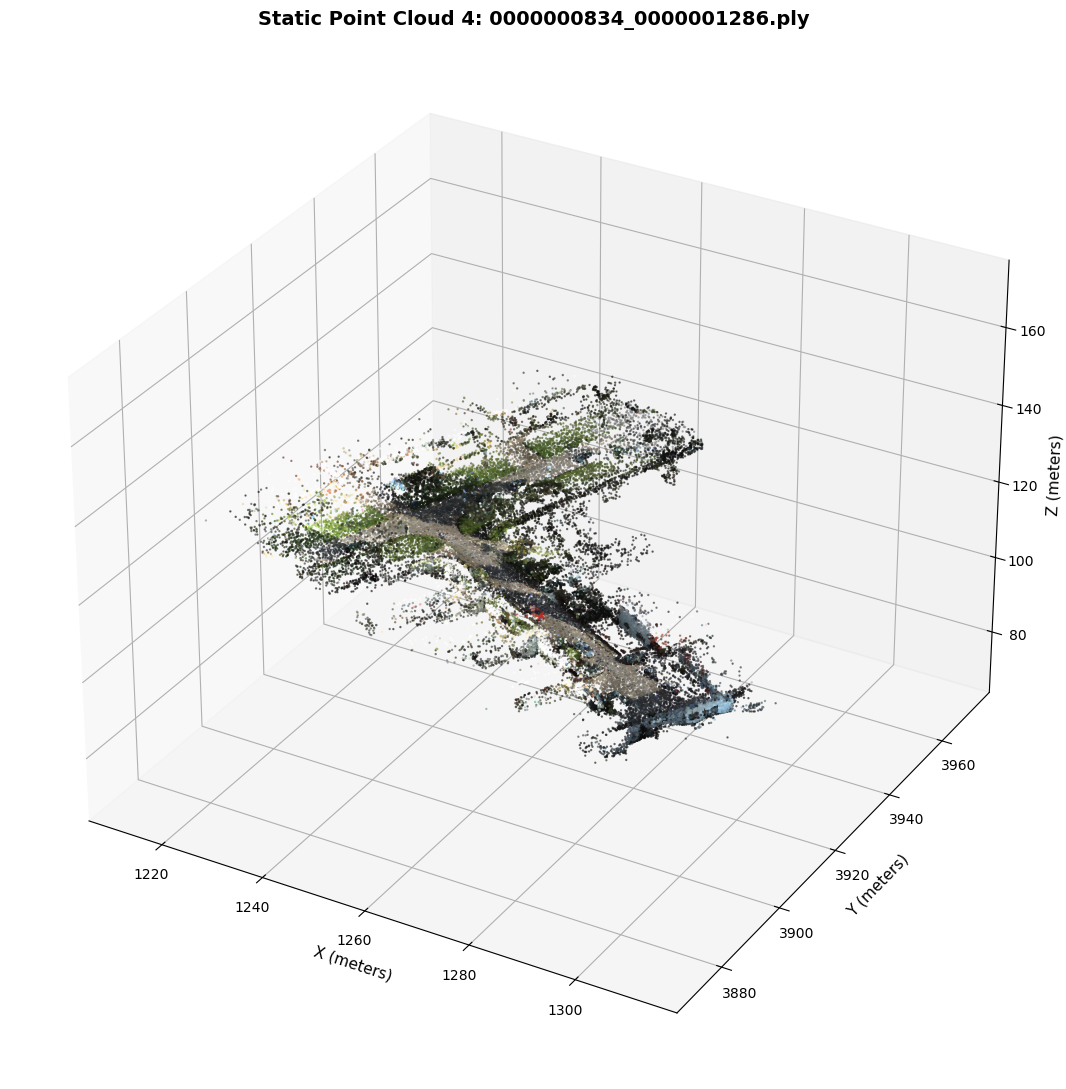

2025-11-04 15:39:12,162 - INFO - Loading static PLY file: ./extracted_3d_images/data_3d_semantics/train/2013_05_28_drive_0000_sync\static\0000001270_0000001549.ply



Loading file 5/10: 0000001270_0000001549.ply


2025-11-04 15:39:12,931 - INFO - Loaded 3365820 points
2025-11-04 15:39:13,002 - INFO -   - 18 unique semantic classes
2025-11-04 15:39:13,002 - INFO -   - 18 unique semantic classes
2025-11-04 15:39:13,073 - INFO -   - 100 unique instances
2025-11-04 15:39:13,073 - INFO -   - 100 unique instances
2025-11-04 15:39:13,103 - INFO - Visualizing point cloud with 3365820 points, colored by rgb
2025-11-04 15:39:13,103 - INFO - Visualizing point cloud with 3365820 points, colored by rgb
2025-11-04 15:39:13,302 - INFO - Subsampled to 50000 points for visualization
2025-11-04 15:39:13,302 - INFO - Subsampled to 50000 points for visualization
2025-11-04 15:39:13,388 - INFO - Point cloud visualization complete
2025-11-04 15:39:13,388 - INFO - Point cloud visualization complete


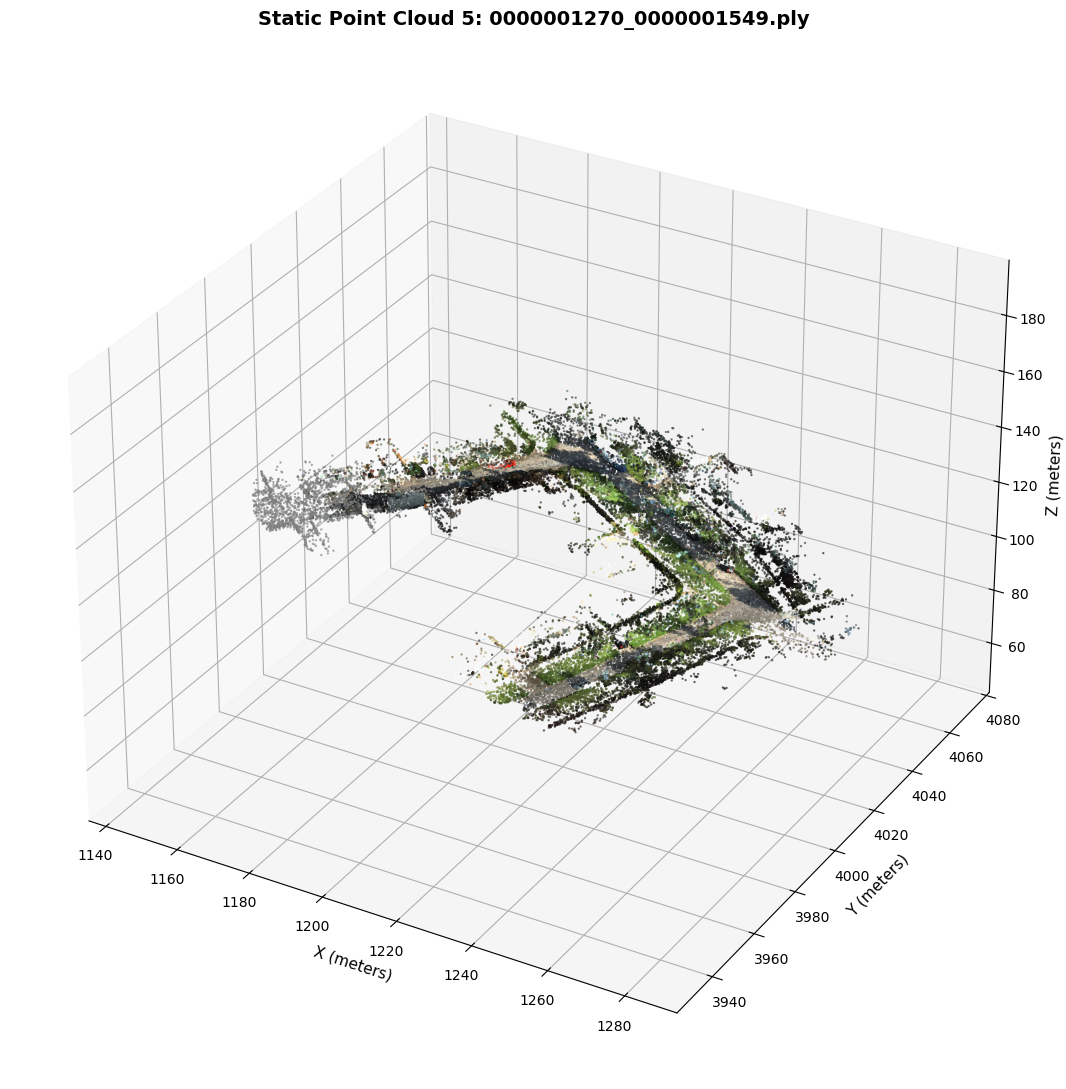

2025-11-04 15:39:14,583 - INFO - Loading static PLY file: ./extracted_3d_images/data_3d_semantics/train/2013_05_28_drive_0000_sync\static\0000001537_0000001755.ply



Loading file 6/10: 0000001537_0000001755.ply


2025-11-04 15:39:15,178 - INFO - Loaded 2476010 points
2025-11-04 15:39:15,235 - INFO -   - 21 unique semantic classes
2025-11-04 15:39:15,235 - INFO -   - 21 unique semantic classes
2025-11-04 15:39:15,305 - INFO -   - 115 unique instances
2025-11-04 15:39:15,305 - INFO -   - 115 unique instances
2025-11-04 15:39:15,339 - INFO - Visualizing point cloud with 2476010 points, colored by rgb
2025-11-04 15:39:15,339 - INFO - Visualizing point cloud with 2476010 points, colored by rgb
2025-11-04 15:39:15,449 - INFO - Subsampled to 50000 points for visualization
2025-11-04 15:39:15,449 - INFO - Subsampled to 50000 points for visualization
2025-11-04 15:39:15,533 - INFO - Point cloud visualization complete
2025-11-04 15:39:15,533 - INFO - Point cloud visualization complete


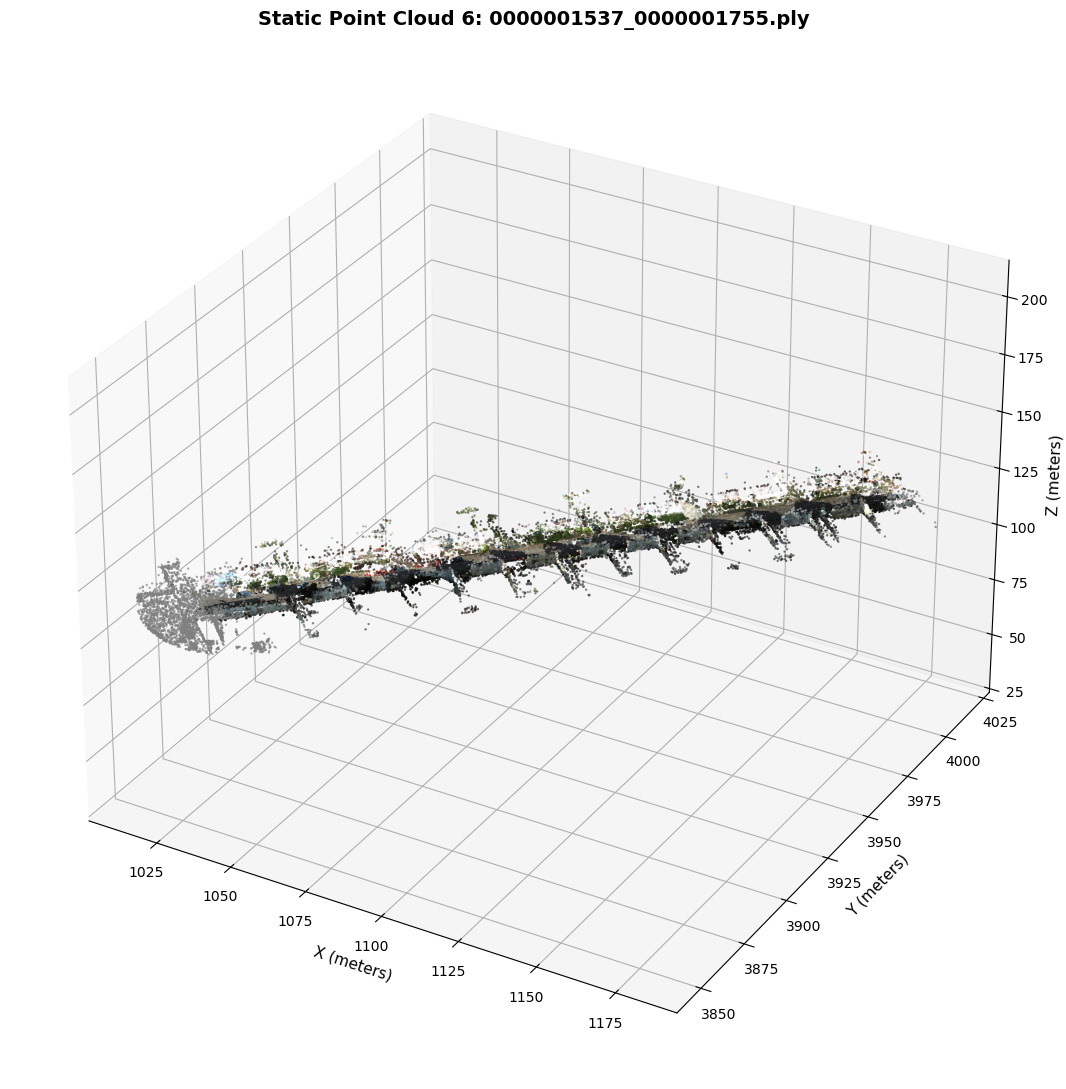

2025-11-04 15:39:16,530 - INFO - Loading static PLY file: ./extracted_3d_images/data_3d_semantics/train/2013_05_28_drive_0000_sync\static\0000001740_0000001991.ply



Loading file 7/10: 0000001740_0000001991.ply


2025-11-04 15:39:17,411 - INFO - Loaded 3007107 points
2025-11-04 15:39:17,470 - INFO -   - 19 unique semantic classes
2025-11-04 15:39:17,534 - INFO -   - 96 unique instances
2025-11-04 15:39:17,470 - INFO -   - 19 unique semantic classes
2025-11-04 15:39:17,534 - INFO -   - 96 unique instances
2025-11-04 15:39:17,602 - INFO - Visualizing point cloud with 3007107 points, colored by rgb
2025-11-04 15:39:17,602 - INFO - Visualizing point cloud with 3007107 points, colored by rgb
2025-11-04 15:39:17,781 - INFO - Subsampled to 50000 points for visualization
2025-11-04 15:39:17,781 - INFO - Subsampled to 50000 points for visualization
2025-11-04 15:39:17,860 - INFO - Point cloud visualization complete
2025-11-04 15:39:17,860 - INFO - Point cloud visualization complete


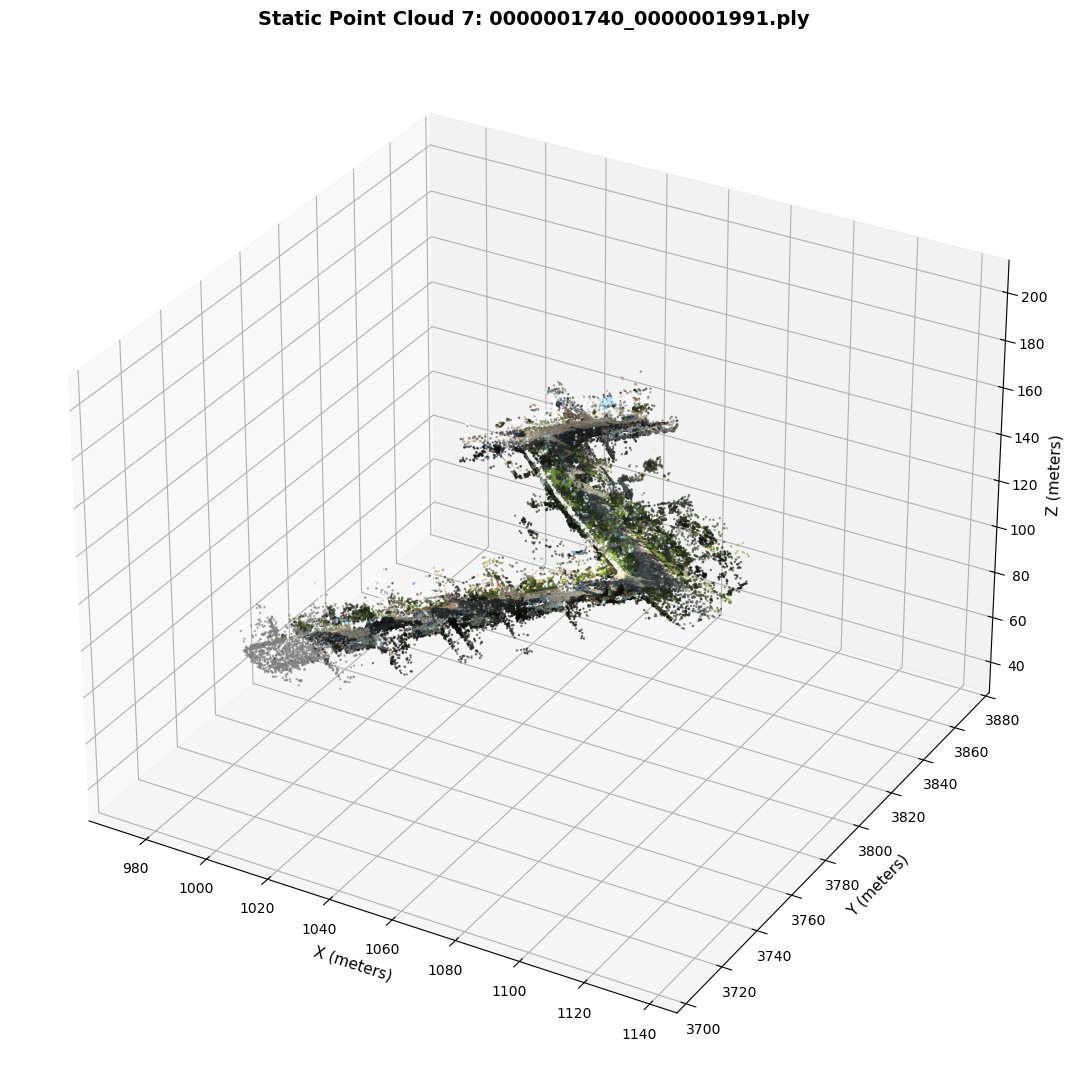

2025-11-04 15:39:18,972 - INFO - Loading static PLY file: ./extracted_3d_images/data_3d_semantics/train/2013_05_28_drive_0000_sync\static\0000001980_0000002295.ply



Loading file 8/10: 0000001980_0000002295.ply


2025-11-04 15:39:19,929 - INFO - Loaded 3674701 points
2025-11-04 15:39:20,041 - INFO -   - 21 unique semantic classes
2025-11-04 15:39:20,041 - INFO -   - 21 unique semantic classes
2025-11-04 15:39:20,162 - INFO -   - 133 unique instances
2025-11-04 15:39:20,162 - INFO -   - 133 unique instances
2025-11-04 15:39:20,189 - INFO - Visualizing point cloud with 3674701 points, colored by rgb
2025-11-04 15:39:20,189 - INFO - Visualizing point cloud with 3674701 points, colored by rgb
2025-11-04 15:39:20,358 - INFO - Subsampled to 50000 points for visualization
2025-11-04 15:39:20,358 - INFO - Subsampled to 50000 points for visualization
2025-11-04 15:39:20,497 - INFO - Point cloud visualization complete
2025-11-04 15:39:20,497 - INFO - Point cloud visualization complete


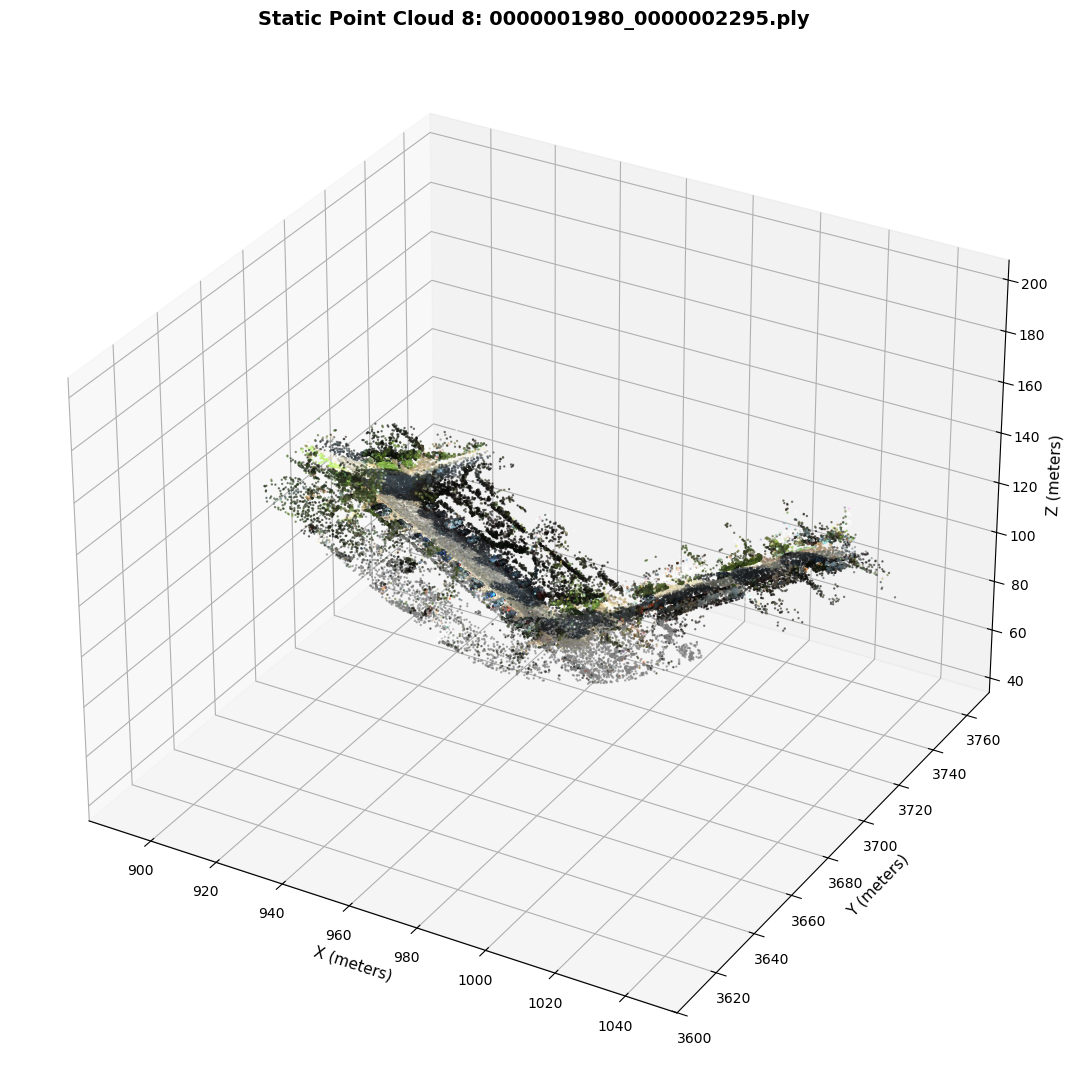

2025-11-04 15:39:21,493 - INFO - Loading static PLY file: ./extracted_3d_images/data_3d_semantics/train/2013_05_28_drive_0000_sync\static\0000002282_0000002514.ply



Loading file 9/10: 0000002282_0000002514.ply


2025-11-04 15:39:22,277 - INFO - Loaded 2712838 points
2025-11-04 15:39:22,333 - INFO -   - 26 unique semantic classes
2025-11-04 15:39:22,333 - INFO -   - 26 unique semantic classes
2025-11-04 15:39:22,392 - INFO -   - 244 unique instances
2025-11-04 15:39:22,421 - INFO - Visualizing point cloud with 2712838 points, colored by rgb
2025-11-04 15:39:22,392 - INFO -   - 244 unique instances
2025-11-04 15:39:22,421 - INFO - Visualizing point cloud with 2712838 points, colored by rgb
2025-11-04 15:39:22,583 - INFO - Subsampled to 50000 points for visualization
2025-11-04 15:39:22,583 - INFO - Subsampled to 50000 points for visualization
2025-11-04 15:39:22,708 - INFO - Point cloud visualization complete
2025-11-04 15:39:22,708 - INFO - Point cloud visualization complete


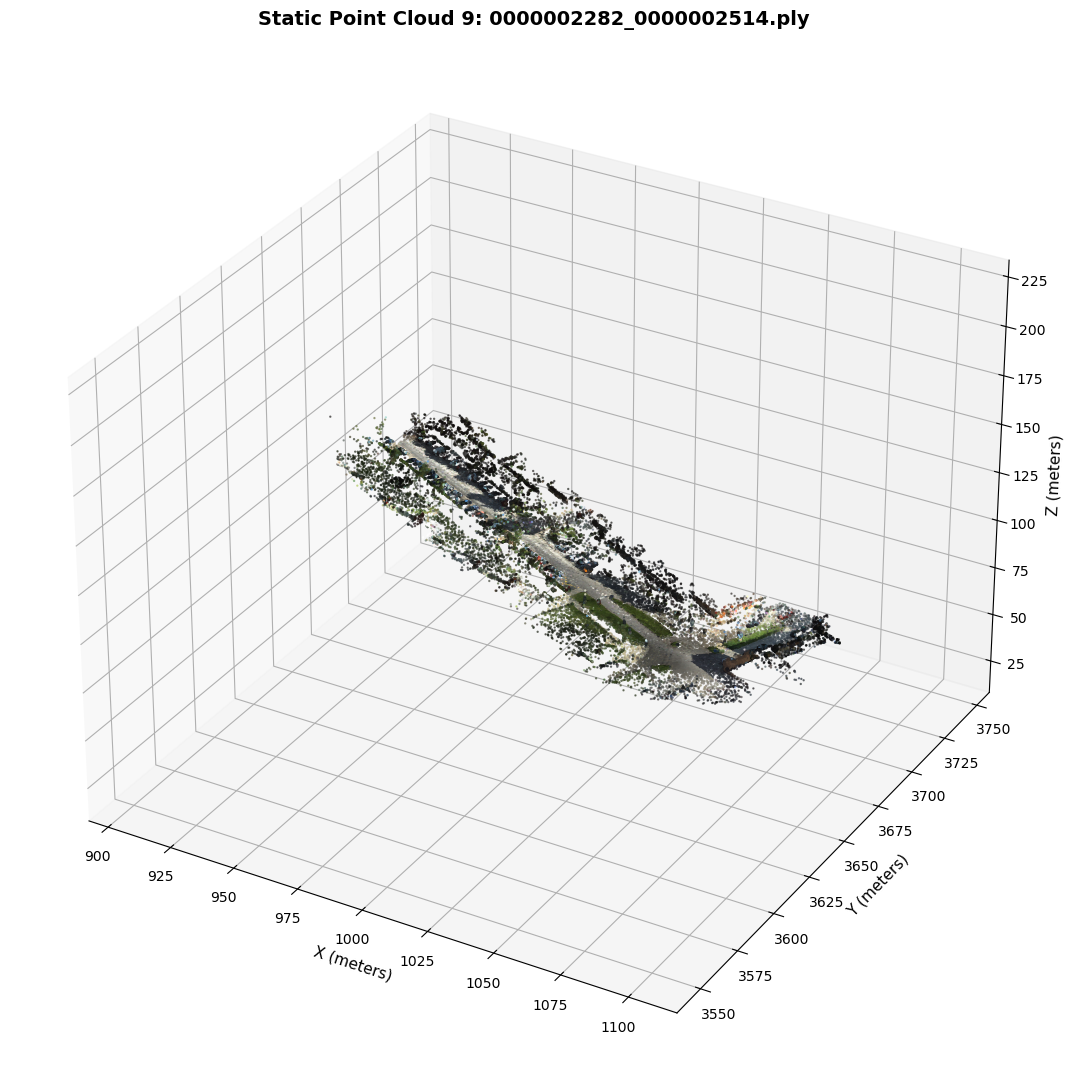

2025-11-04 15:39:23,710 - INFO - Loading static PLY file: ./extracted_3d_images/data_3d_semantics/train/2013_05_28_drive_0000_sync\static\0000002501_0000002706.ply



Loading file 10/10: 0000002501_0000002706.ply


2025-11-04 15:39:24,454 - INFO - Loaded 2744597 points
2025-11-04 15:39:24,516 - INFO -   - 24 unique semantic classes
2025-11-04 15:39:24,516 - INFO -   - 24 unique semantic classes
2025-11-04 15:39:24,640 - INFO -   - 130 unique instances
2025-11-04 15:39:24,667 - INFO - Visualizing point cloud with 2744597 points, colored by rgb
2025-11-04 15:39:24,640 - INFO -   - 130 unique instances
2025-11-04 15:39:24,667 - INFO - Visualizing point cloud with 2744597 points, colored by rgb
2025-11-04 15:39:24,799 - INFO - Subsampled to 50000 points for visualization
2025-11-04 15:39:24,799 - INFO - Subsampled to 50000 points for visualization
2025-11-04 15:39:24,912 - INFO - Point cloud visualization complete
2025-11-04 15:39:24,912 - INFO - Point cloud visualization complete


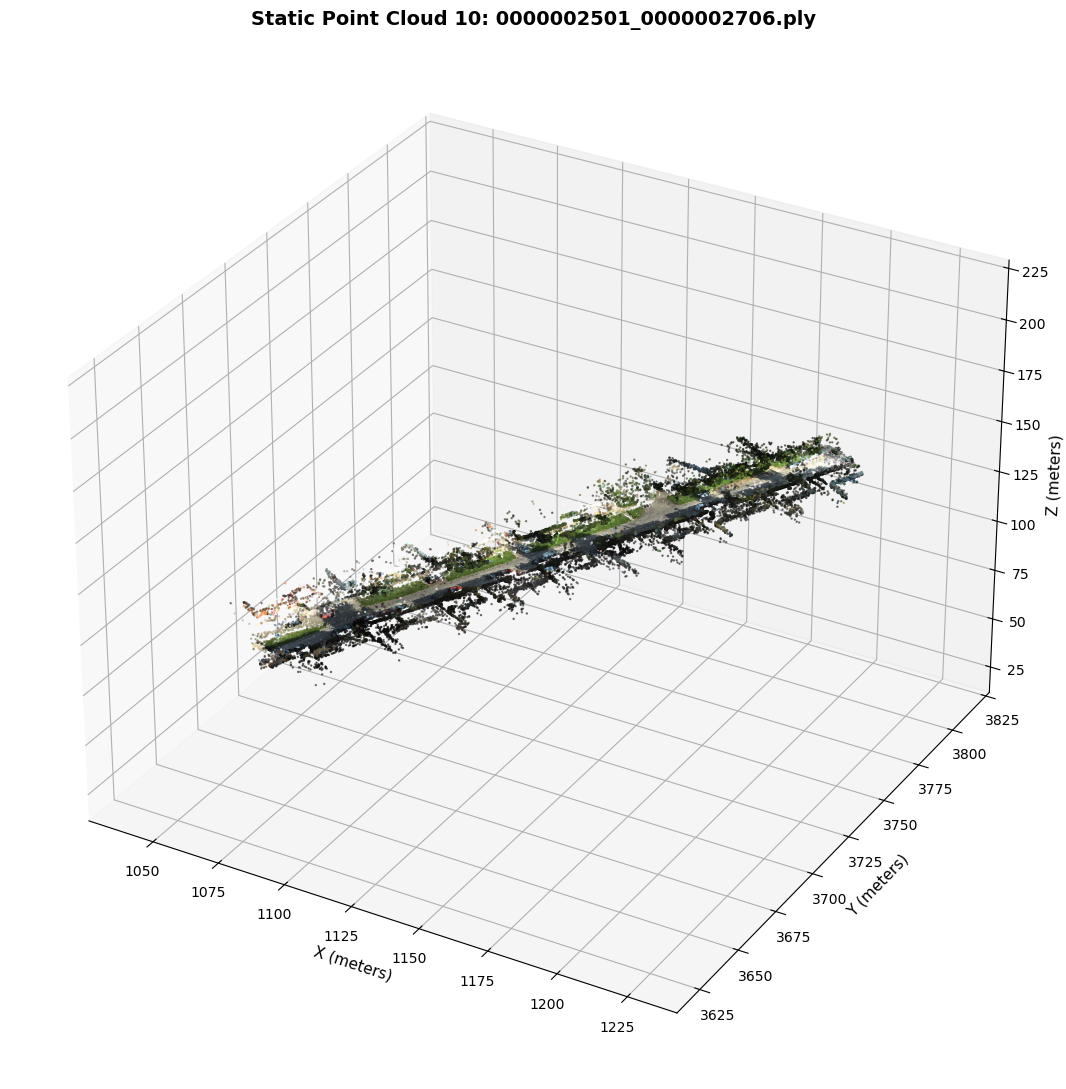

In [113]:
# Load and visualize first 10 static point cloud files
num_files_static = min(10, len(static_files))

for i in range(num_files_static):
    ply_file = os.path.join(static_dir, static_files[i])
    print(f"\n{'='*60}")
    print(f"Loading file {i+1}/{num_files_static}: {static_files[i]}")
    print(f"{'='*60}")
    
    # Load the point cloud
    data = load_ply_file(ply_file, point_type='static')
    
    # Visualize with RGB colors
    visualize_point_cloud(data, 
                         title=f"Static Point Cloud {i+1}: {static_files[i]}", 
                         point_size=0.5, 
                         subsample=50000,
                         color_by='rgb')